# Calibration

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Load](#toc2_)    
- 3. [Set steady state](#toc3_)    
- 4. [Moments](#toc4_)    
- 5. [Figures](#toc5_)    
- 6. [Consumption in uneqmployment](#toc6_)    
- 7. [MPCs](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig, save_fig

## 2. <a id='toc2_'></a>[Load](#toc0_)

In [2]:
model = FullHANKSAMModelClass(name='baseline_ss')
model.load()
model.par.PIH_share = 1e-8
model.create_beta_grid()

In [3]:
par = model.par
ss = model.ss
path = model.path

## 3. <a id='toc3_'></a>[Set steady state](#toc0_)

In [4]:
import steady_state
def set_ss(model):

    ss = model.ss

    steady_state.find_ss_SAM(model)

    # a. shocks
    ss.shock_beta = 1.0

    # b. fixed
    ss.RealR_ex_post = ss.RealR = par.RealR_ss
    ss.phi_obar = par.phi_obar_ss
    ss.u_bar = par.u_bar_ss
    ss.tau = par.tau_ss
    ss.Pi = 1.0
    ss.R = ss.RealR*ss.Pi

    # c. dividends
    ss.adj_Vj = (1-ss.u)*ss.mu
    ss.adj_Vv = (ss.entry*ss.Vv)/(1+par.xi)
    ss.adj_Pi = par.phi/2*(ss.Pi-ss.Pi)**2*ss.Y
    ss.adj = ss.adj_Vj+ss.adj_Vv+ss.adj_Pi

    ss.div = ss.Y-(ss.w-ss.retention_subsidy)*(1-ss.u)-(1-par.adj_virtual_share)*ss.adj

    # d. household behavior
    ss.hh_div = 0.0
    ss.hh_transfer = 0.0

In [5]:
set_ss(model)
model.calibrate_dur_dep_UE()

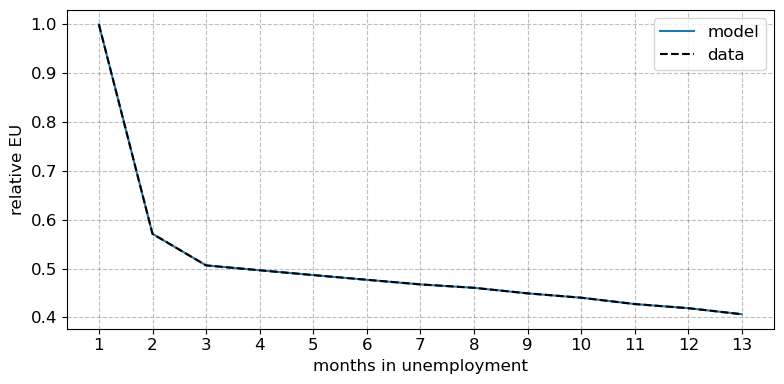

In [6]:
fig,ax = create_fig(figsize=(8,6/1.5))  

# a. realtive UEs in model
x = np.arange(1,par.Nu+1)
y = [model.ss.z_trans[0,0,i_z,0]/model.ss.z_trans[0,0,1,0] for i_z in range(1,par.Nz) if par.i_UI_hh[0,i_z] == 1]
ax.plot(x,y,label='model')

# b. data
x = np.arange(1,par.UEs_taget.size+1)
ax.plot(x,np.exp(par.UEs_taget),color='black',ls='--',label='data')

ax.set_xticks(np.arange(1,par.Nu+1,1));
ax.set_ylabel('relative EU')
ax.set_xlabel('months in unemployment')
ax.legend(frameon=True);

fig.tight_layout()
fig.savefig('results/UEs.pdf')

## 4. <a id='toc4_'></a>[Moments](#toc0_)

In [7]:
model.find_ss(calib_beta=False)

In [8]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)
model.calc_moms_ss(do_print=True)

household problem in ss solved in 11.3 secs [4213 iterations]


household problem in ss simulated in 0.7 secs [1740 iterations]


MPC_qtr                   =     40.7
C_drop_ss                 =    -19.9
C_drop_ex                 =    -43.1
A_hh                      =      0.7
moments in ss calculated in 7.4 secs


## 5. <a id='toc5_'></a>[Figures](#toc0_)

In [9]:
model_ = FullHANKSAMModelClass(name='baseline_vec',par={'Nfix':13})
model_.load_data()
set_ss(model_)
model_.calibrate_dur_dep_UE()
model_.solve_hh_ss(do_print=True)
model_.simulate_hh_ss(do_print=True)
model_.calc_moms_ss(vec=True,do_print=True)

household problem in ss solved in 52.9 secs [4117 iterations]


household problem in ss simulated in 2.9 secs [2180 iterations]


MPC_qtr                   =     45.0 | vec: [100.0 99.9 55.8 35.1 19.1 12.2 8.5 6.3 5.0 4.3 3.9 3.7 3.6 ]
C_drop_ss                 =    -24.0 | vec: [-36.8 -36.9 -36.0 -32.2 -26.7 -20.8 -15.8 -12.2 -9.8 -8.4 -7.6 -7.2 -7.0 ]
C_drop_ex                 =    -40.8 | vec: [-100.0 -31.8 -27.1 -24.3 -21.9 -18.4 -14.5 -11.2 -8.9 -7.6 -6.8 -6.4 -6.2 ]
A_hh                      =      0.5 | vec: [0.0 0.0 0.0 0.1 0.2 0.4 0.6 0.9 1.1 1.3 1.5 1.5 1.6 ]
moments in ss calculated in 14.3 secs


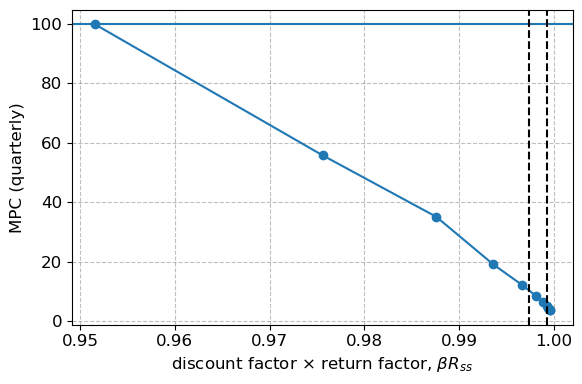

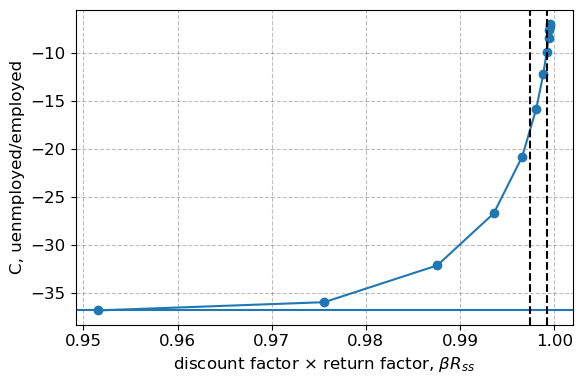

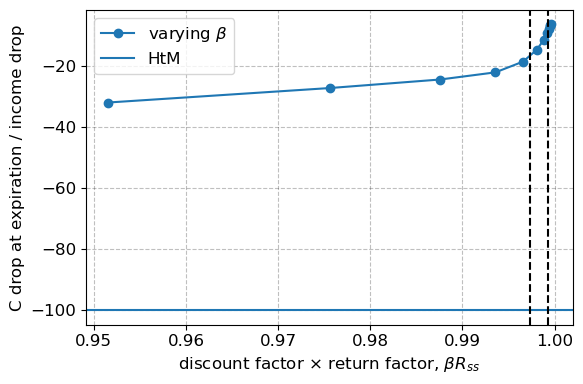

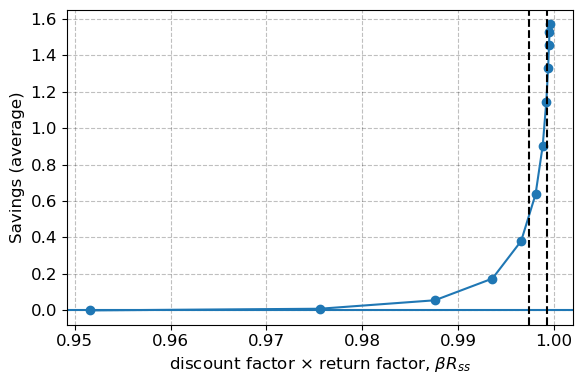

In [10]:
for momname,ylabel in [('MPC_qtr_vec','MPC (quarterly)'),
                       ('C_drop_ss_vec','C, uenmployed/employed'),
                       ('C_drop_ex_vec','C drop at expiration / income drop'),
                       ('A_hh_vec','Savings (average)')]:

    fig,ax = create_fig()
    x = model_.par.beta_grid[1:]*ss.RealR
    y = model_.moms[momname][1:]
    ax.plot(x,y,'-o',label='varying $\\beta$')
    ax.axhline(model_.moms[momname][0],label='HtM')
    if par.Nfix == 3: ax.axvline(par.beta_min*ss.RealR,color='black',ls='--')
    ax.axvline(par.beta_max*ss.RealR,color='black',ls='--')

    if momname == 'C_drop_ex_vec': ax.legend(frameon=True)
    ax.set_xlabel('discount factor $\\times$ return factor, $\\beta R_{{ss}}$')
    ax.set_ylabel(ylabel)

    fig.tight_layout()
    fig.savefig(f'results/discount_factors_{momname[:-4]}.pdf')

    plt.show()

## 6. <a id='toc6_'></a>[Consumption in uneqmployment](#toc0_)

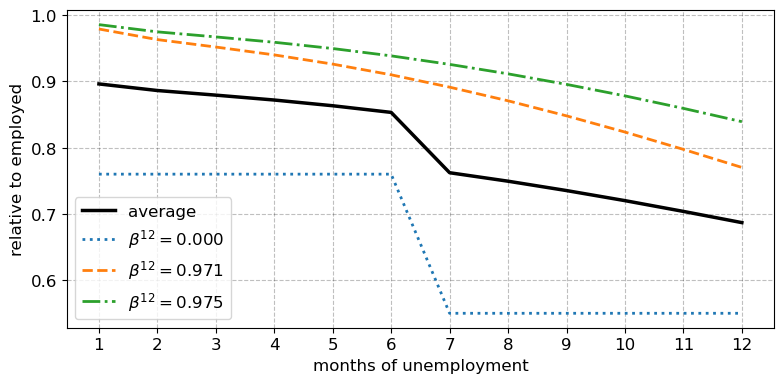

In [11]:
fig,ax = create_fig(figsize=(8,6/1.5))  

# baseline
C_e,C_u,C_u_dur = model.calc_Cs()
ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,ls='-',lw=2.5,color='black',label='average')

for i_fix,ls in zip(range(par.Nfix),[':','--','-.']):
    C_e,C_u,C_u_dur = model.calc_Cs(i_fix=i_fix)
    ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,lw=2,ls=ls,label=f'$\\beta^{{12}} = {par.beta_grid[i_fix]**12:.3f}$')

# details
ax.set_xticks(np.arange(1,par.Nu));
ax.set_xlabel('months of unemployment')
ax.set_ylabel('relative to employed')
ax.legend(frameon=True,ncol=1)

fig.tight_layout()
fig.savefig(f'results/c_upon_u.pdf')

## 7. <a id='toc7_'></a>[MPCs](#toc0_)

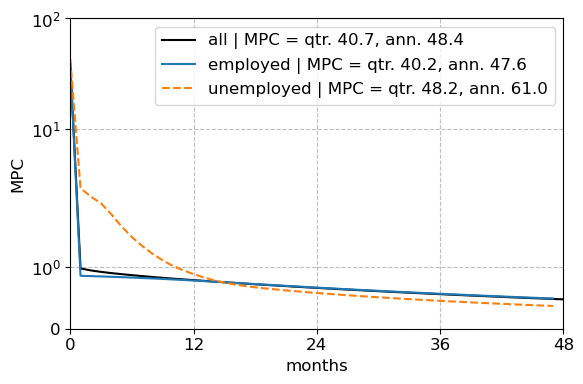

In [12]:
# a. path
hh_transfer_ss = ss.hh_transfer
dy = 0.01*(1-ss.tau)*ss.w
custom_paths = {'hh_transfer':hh_transfer_ss*np.ones(par.T)}
custom_paths['hh_transfer'][0] += dy

# b. unemployed
Dbeg_u = ss.Dbeg.copy()
Dbeg_u[:,0,:] = 0.0
Du = np.sum(Dbeg_u)
Dbeg_u /= Du

path_u_base = model.decompose_hh_path(do_print=False,Dbeg=Dbeg_u,use_inputs=[],custom_paths=custom_paths);
path_u = model.decompose_hh_path(do_print=False,Dbeg=Dbeg_u,use_inputs=['hh_transfer'],custom_paths=custom_paths);

MPC_u = (path_u.C_hh[:,0]-path_u_base.C_hh[:,0])/dy
MPC_u_qtr = np.sum(path_u.C_hh[:3,0]-path_u_base.C_hh[:3,0])/dy
MPC_u_ann = np.sum(path_u.C_hh[:12,0]-path_u_base.C_hh[:12,0])/dy

# c. employed
Dbeg_e = ss.Dbeg.copy()
Dbeg_e[:,1:,:] = 0.0
Dbeg_e /= np.sum(Dbeg_e)

path_e_base = model.decompose_hh_path(do_print=False,Dbeg=Dbeg_e,use_inputs=[],custom_paths=custom_paths);
path_e = model.decompose_hh_path(do_print=False,Dbeg=Dbeg_e,use_inputs=['hh_transfer'],custom_paths=custom_paths);

MPC_e = (path_e.C_hh[:,0]-path_e_base.C_hh[:,0])/dy
MPC_e_qtr = np.sum(path_e.C_hh[:3,0]-path_e_base.C_hh[:3,0])/dy
MPC_e_ann = np.sum(path_e.C_hh[:12,0]-path_e_base.C_hh[:12,0])/dy

# d. total
path_all = model.decompose_hh_path(do_print=False,use_inputs=['hh_transfer'],custom_paths=custom_paths);
MPC_all = (path_all.C_hh[:,0]-ss.C_hh)/dy
MPC_all_qtr = np.sum(path_all.C_hh[:3,0]-ss.C_hh)/dy
MPC_all_ann = np.sum(path_all.C_hh[:12,0]-ss.C_hh)/dy

# e. figure
fig,ax = create_fig()

ax.plot(MPC_all*100,label=f'all | MPC = qtr. {MPC_all_qtr*100:.1f}, ann. {MPC_all_ann*100:.1f}',color='black')
ax.plot(MPC_e[:48]*100,label=f'employed | MPC = qtr. {MPC_e_qtr*100:.1f}, ann. {MPC_e_ann*100:.1f}',ls='-')
ax.plot(MPC_u[:48]*100,label=f'unemployed | MPC = qtr. {MPC_u_qtr*100:.1f}, ann. {MPC_u_ann*100:.1f}',ls='--')

ax.set_ylim([0,100])
ax.set_yscale('symlog')
save_fig(fig,ax,f'MPCs',legend=True,ylabel='MPC')